## RNN LSTM Text Classificaiton model

### Dependencies and Libraries

In [1]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('drive/MyDrive/School Work/CS4248/News Labelling Project')

### Reading in data into pd dataframes, data viewing

In [2]:
# Read CSV file in
train_path = './raw_data/clean_fulltrain.csv'
df = pd.read_csv(train_path, header=None)

print(type(df))

# Samples, number of columns, 0 = labels, column 1 = text
print('Total rows, Total Columns: ' + str(df.shape))
df.sample(5) # Random sample values to see

<class 'pandas.core.frame.DataFrame'>
Total rows, Total Columns: (48854, 2)


,0,1
3934,1,sources inside local man eric chens brain conf...
19780,2,ferguson rioters threatening next unless give ...
35789,3,new fake hiv test target poor updated response...
38205,3,tennessee town ability track drivers license p...
36605,3,canadian free man hasnt paid taxes 17 yearsctv


In [3]:
# Get number of labels for each task
classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']
label_numbers = [1,2,3,4]

for label in label_numbers:
    print(classes[label-1] + ': ' + str((df[0] == label).sum()))
print(df[0].value_counts())

Satire: 14047
Hoax: 6942
Propaganda: 17870
Reliable News: 9995
3    17870
1    14047
4     9995
2     6942
Name: 0, dtype: int64


### Count number of unique words in the entire dataset

In [4]:
# Count number of unique words
def unique_word_counter(texts):
    count = Counter() # Dictionary type
    # Access an entire string
    for text in texts:
        # Split each string into individual words separated by whitespace
        for word in text.split():
            count[word] += 1
    return count

In [5]:
# Run counter
counts = unique_word_counter(df[1])
unique_words_count = len(counts)
print('Number of unique words: ' + str(unique_words_count))
print('Most Common Words:')
counts.most_common(10)

Number of unique words: 252019
Most Common Words:


[('said', 95152),
 ('us', 78350),
 ('one', 64372),
 ('would', 61931),
 ('people', 58751),
 ('government', 45594),
 ('like', 44459),
 ('new', 43537),
 ('time', 43174),
 ('also', 40434)]

### Prepare datasets, convert into numpy format for Keras Model

In [6]:
X_train = df[1].to_numpy()
y_train = df[0].to_numpy()

y_train = pd.get_dummies(df[0]).values
print(type(y_train))

<class 'numpy.ndarray'>


### Tokenise words into numbers
- Each word will be assigned a specific number, according to how many unique words we have
- Inspired from this [Youtube Video](https://www.youtube.com/watch?v=kxeyoyrf2cM&ab_channel=PythonEngineer)

In [7]:
# Each string is turned into a sequence of integers
tokenizer = Tokenizer(num_words=unique_words_count)
tokenizer.fit_on_texts(X_train)

# X_test = tokenizer.texts_to_sequences(X_test)

### Pad sequences to a common length

In [8]:
padding_length = 1000
# X_test = pad_sequences(X_test, maxlen=padding_length, padding="post", truncating="post")

### Load model for evaluation

In [9]:
from tensorflow.python.client import device_lib
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
print(device_lib.list_local_devices())

No GPU found
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4931026508871628355
xla_global_id: -1
]


In [10]:
def convert_to_format(text, tokenizer, padding_length):
    tokenized_text = tokenizer.texts_to_sequences([text])
    return pad_sequences(tokenized_text, maxlen=padding_length, padding="post", truncating="post")

In [14]:
from keras.models import load_model
model = load_model('./TrainedModels/RNN_LSTM_Best.h5') # This is the better model

text_to_test = ['']
predictions = []
for text in text_to_test:
    formatted_text = convert_to_format(text, tokenizer, padding_length)
    prediction = model.predict(formatted_text)
    # print(prediction)
    predictions.append(prediction)

In [15]:
# Print prediction for text
classes = ['Satire', 'Hoax', 'Propaganda', 'Reliable News']
for prediction in predictions:
    label = np.argmax(prediction)
    print(classes[label])

Reliable News


### Predicting sentences of certain length

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def score_model(predictions, target_value):
    score = f1_score(target_value, predictions, average='macro')
    print('F1 score = {}'.format(score))
    accuracy = accuracy_score(target_value, predictions)
    print('Accuracy = {}'.format(accuracy))
    precision = precision_score(target_value, predictions, average='micro')
    print('Precision = {}'.format(precision))
    print()

    # Print confusion matrix
def print_confusion_matrix(predictions, true_labels):
    cm = confusion_matrix(true_labels, predictions)
    cm_plot = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm_plot.plot()

In [47]:
test_path = './raw_data/clean_balancedtest.csv'
test_df = pd.read_csv(test_path, header=None)

upperbound = 350
lowerbound = 0
labels = []
predictions = []

for index, row in test_df.iterrows():
    label = row[0]
    text = row[1]
    if len(text) > lowerbound and len(text) < upperbound:
        formatted_text = convert_to_format(text, tokenizer, padding_length)
        prediction = model.predict(formatted_text)
        predictions.append(np.argmax(prediction))
        labels.append(label-1)


In [48]:
score_model(predictions, labels)

F1 score = 0.4871630295250321
Accuracy = 0.5444444444444444
Precision = 0.5444444444444444



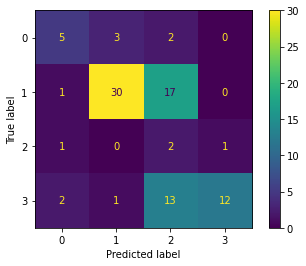

In [49]:
print_confusion_matrix(predictions, labels)